In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Section 1 - Clean GPS data

In [4]:
fileindex = np.arange(10,1780,10)
Data_length= np.arange(0,177)

### 1.1 Read in all GPS data

In [5]:
data_list = []
missing_indices = []

for i in fileindex :
    
    try:                                            ### try and except used to skip missing indexes (missing data)
        file = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/GPS_files/CERN_OPMT'+f"{i:04}"+'.clk')  
                                                   ### f"{i:04}",  f for string, 04 to ensure all file numbers have 4 digits

    except:  
        missing_indices.append(i)
        
    data_list.append(file)

### 1.2 Get Fractional Frequencies.  (Slope of time vs clock offset)

In [6]:
m_list = []                                         ## list for slopes
mjd_list = []                                       ## list for mean mjd times

for n in Data_length :
    
    poi = data_list[n]                              
    
    m,b0 = np.polyfit(poi['Epoch_mjd']*84600,poi['diff_CLK(ns)']*10**(-9), 1)     ## fit slope and c to dataset i
    
    m_list.append(m)                                ## add slope to list
    mjd_list.append(poi['Epoch_mjd'].mean())        ## get mean mjd time and add to list

Text(0.5, 1.0, 'Plot of Fractional Frequency vs MJD (days)')

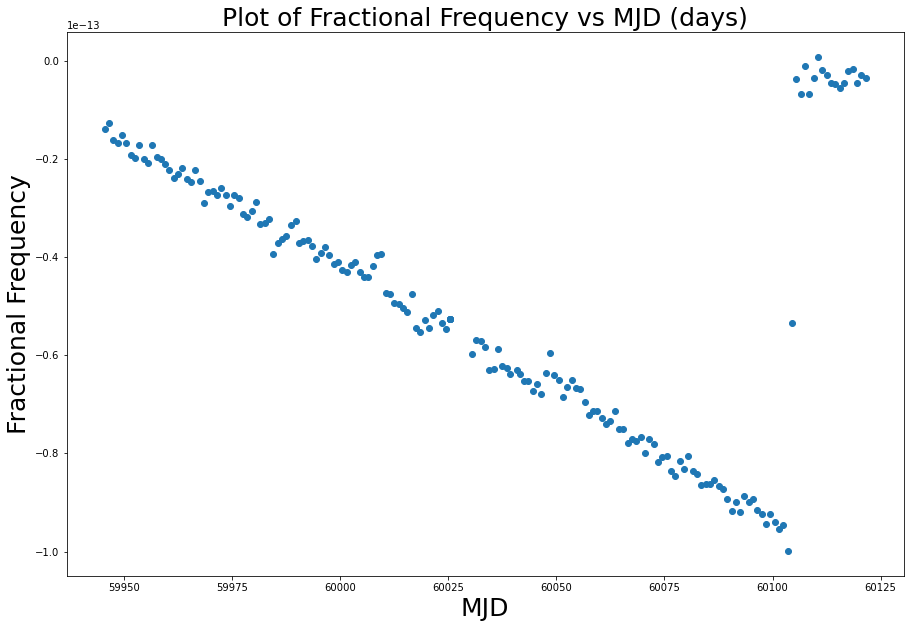

In [7]:
plt.figure(figsize=(15,10))

plt.scatter(mjd_list,np.array(m_list)-(9.81/(299792458)**2)*442.420)       ## add offset to y axis to reset to 0 
                                                                           ## offset due to gravitational redshift

plt.xlabel('MJD',fontsize=25)
plt.ylabel('Fractional Frequency',fontsize=25)
plt.title('Plot of Fractional Frequency vs MJD (days)',fontsize=25)

# Section 2 - Clean CSF data

### 2.1 Read in all CSF files and concatenate

In [8]:
csf_file = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [59945.0]-[59976.0] 2023-01-01T00-00-00Z - 2023-02-01T00-00-00Z.txt',delimiter='\t')
csf_file1 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [59976.0]-[60004.0] 2023-02-01T00-00-00Z - 2023-03-01T00-00-00Z.txt',delimiter='\t')
csf_file2 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [60004.0]-[60035.0] 2023-03-01T00-00-00Z - 2023-04-01T00-00-00Z.txt',delimiter='\t')
csf_file3 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [60035.0]-[60065.0] 2023-04-01T00-00-00Z - 2023-05-01T00-00-00Z.txt',delimiter='\t')
csf_file4 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [60065.0]-[60096.0] 2023-05-01T00-00-00Z - 2023-06-01T00-00-00Z.txt',delimiter='\t')
csf_file5 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [60096.0]-[60126.0] 2023-06-01T00-00-00Z - 2023-07-01T00-00-00Z.txt',delimiter='\t')
csf_file6 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [59884.0]-[59914.0] 2022-11-01T00-00-00Z - 2022-12-01T00-00-00Z.txt',delimiter='\t')
csf_file7 = pd.read_csv(r'/eos/user/e/elsweene/SWAN_projects/CsF_files/Alpha 1-hour data [59914.0]-[59945.0] 2022-12-01T00-00-00Z - 2022-13-01T00-00-00Z.txt',delimiter='\t')

In [9]:
all_csf_files = [csf_file,csf_file1,csf_file2,csf_file3,csf_file4,csf_file5,csf_file6,csf_file7]
frame = pd.concat(all_csf_files, axis=0, ignore_index=True)

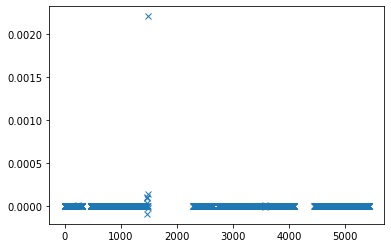

In [57]:
plt.plot(frame['f0'],'x')

### 2.2 Filter Concatenated Data

In [52]:
filter2=(frame[abs(frame['f0'])<1.1e-13])

In [38]:
# bound for 2 sd above/below mean

Bound1= filter2['f0'].rolling(window=24).mean().dropna() + 2*filter2['f0'].rolling(window=24).std().dropna() 
Bound2 = filter2['f0'].rolling(window=24).mean().dropna() - 2*filter2['f0'].rolling(window=24).std().dropna()

In [39]:
# Add new columns to dataset

filter_w_bounds = filter2.assign(Upperbound=Bound1)

In [40]:
filtered_data_w_bounds = filter_w_bounds.assign(Lowerbound=Bound2)

In [41]:
# Remove any data outside bounds

Outside_Upper = filtered_data_w_bounds[(filtered_data_w_bounds['f0'])<filtered_data_w_bounds['Upperbound']] 

In [42]:
Outside_Bounds = Outside_Upper[(Outside_Upper['f0'])>Outside_Upper['Lowerbound']]

In [43]:
## Convert time in CSf dataset to same as gps time (days)

Outside_Bounds1 = Outside_Bounds.assign(TimeStamp = Outside_Bounds['Bin Start MJD Days']+ (Outside_Bounds['Bin End Seconds']/86400))

In [44]:
Truncated_Time_data = Outside_Bounds1[(Outside_Bounds1['TimeStamp'])>59960]          ## Cut out broken csf clock data

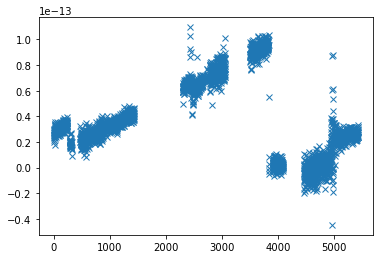

In [67]:
plt.plot(filter2['f0'],'x')

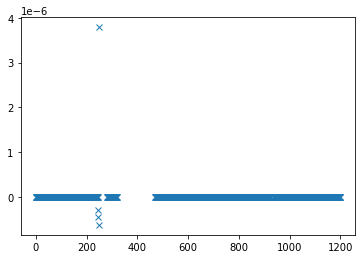

### 2.3 Plot GPS and CSF data 

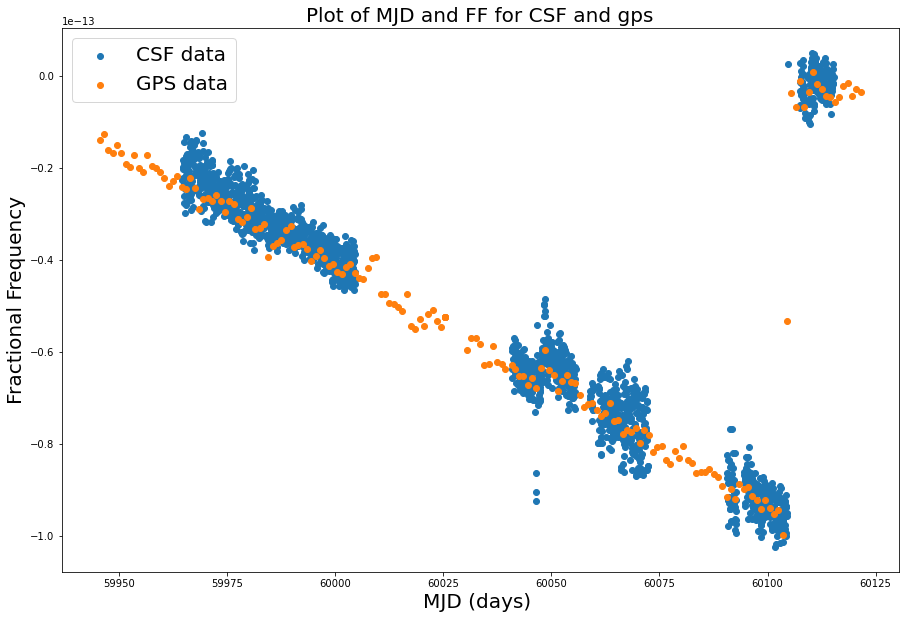

In [18]:
## Plot of CSF data vs GPS data 

plt.figure(figsize=(15,10))

plt.scatter(Truncated_Time_data['TimeStamp'],-1*Truncated_Time_data['f0'],label='CSF data')
plt.scatter(mjd_list,np.array(m_list)-(9.81/(299792458)**2)*442.420,label='GPS data')

plt.title('Plot of MJD and FF for CSF and gps',fontsize=20)
plt.xlabel('MJD (days) ',fontsize=20)
plt.ylabel('Fractional Frequency',fontsize=20)

plt.legend(fontsize=20)

### 2.4 Cut data to zoom into section of continuous data 

In [19]:
## Cut CSF data

Zoom_in_left_CFS = Outside_Bounds1[(Outside_Bounds1['TimeStamp'])>59960]
Zoom_in_CFS = Zoom_in_left_CFS[(Zoom_in_left_CFS['TimeStamp'])<60010]

In [20]:
## Convert gps data into dataframe

data = {'MJD': mjd_list,
        'FF': m_list}
  
df_gps = pd.DataFrame(data, columns=['MJD', 'FF'])

In [21]:
## Cut GPS data

Zoom_in_left_gps = df_gps[df_gps['MJD']>59960]
Zoom_in_gps = Zoom_in_left_gps[(Zoom_in_left_gps['MJD'])<60010]

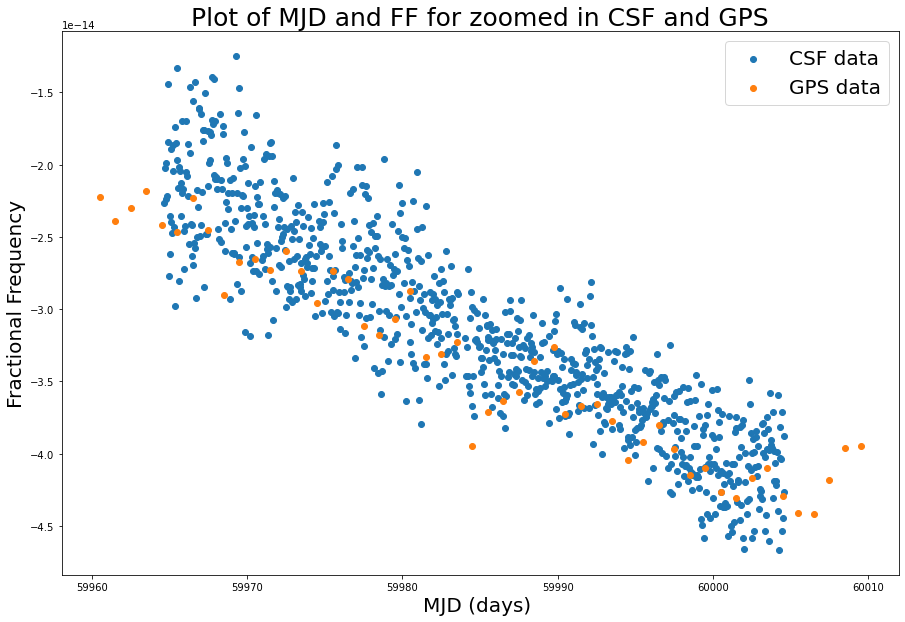

In [22]:
plt.figure(figsize=(15,10))

plt.scatter(Zoom_in_CFS['TimeStamp'],-1*Zoom_in_CFS['f0'],label='CSF data')
plt.scatter(Zoom_in_gps['MJD'],Zoom_in_gps['FF']-(9.81/(299792458)**2)*442.420,label='GPS data')

plt.title('Plot of MJD and FF for zoomed in CSF and GPS',fontsize=25)
plt.xlabel('MJD (days) ',fontsize=20)
plt.ylabel('Fractional Frequency',fontsize=20)

plt.legend(fontsize=20)

## 2.5 Cut Raw GPS data to continuous section (clock offset not ff)

In [23]:
gps_combined = pd.concat(data_list, axis=0, ignore_index=True)

In [24]:
Zoom_in_left_rawgps = gps_combined[(gps_combined['Epoch_mjd'])>59960]

In [25]:
Zoom_in_raw_gps = Zoom_in_left_rawgps[(Zoom_in_left_rawgps['Epoch_mjd'])<60010]

Text(0, 0.5, 'Clock Offset (ns)')

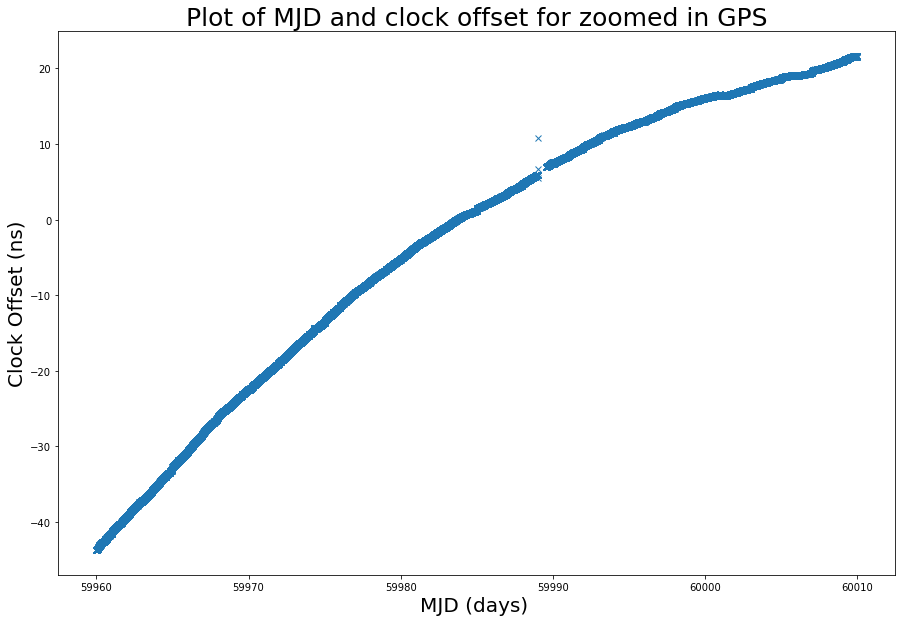

In [26]:
plt.figure(figsize=(15,10))

plt.plot(np.array(Zoom_in_raw_gps['Epoch_mjd']),np.array(Zoom_in_raw_gps['diff_CLK(ns)']),'x')


plt.title('Plot of MJD and clock offset for zoomed in GPS',fontsize=25)
plt.xlabel('MJD (days) ',fontsize=20)
plt.ylabel('Clock Offset (ns)',fontsize=20)

# Section 3 - Save filtered data sets

In [27]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [28]:
## Complete CSF Data filtered

Truncated_Time_data.to_csv(save_dir+"Complete_CSF_Data_filtered.csv", index=False)

In [29]:
## Complete GPS Data filtered 

df_gps.to_csv(save_dir+"Complete_GPS_Data_filtered.csv", index=False)

In [30]:
## Zoomed in CSF Data filtered

Zoom_in_CFS.to_csv(save_dir+"Zoom_in_CSF_Data_filtered.csv", index=False)

In [31]:
## Zoomed in GPS Data filtered

Zoom_in_gps.to_csv(save_dir+"Zoom_in_GPS_Data_filtered.csv", index=False)

In [32]:
## Zoomed in clock offset GPS Data 

Zoom_in_raw_gps.to_csv(save_dir + "Zoom_in_Raw_GPS_Data_filtered.csv", index=False)

In [68]:
## Complete CSF data frame unfiltered - to generate synthetic data

frame.to_csv(save_dir + "CSF_data_frame_unfiltered.csv", index=True)

In [69]:
## Complete CSF data frame with major outliers removed - to generate synthetic data
filter2.to_csv(save_dir + "CSF_data_frame_filter2.csv", index=True)